<a href="https://colab.research.google.com/github/ffangsong/NLP-Projects/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

{}

In [0]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
ls

sample_data/


In [0]:
pwd

'/content'

In [0]:
!cp kaggle.json ~/.kaggle

In [0]:
!chmod -600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c word2vec-nlp-tutorial

  0% 0.00/276k [00:00<?, ?B/s]
100% 276k/276k [00:00<00:00, 81.9MB/s]
 65% 17.0M/26.0M [00:00<00:00, 39.3MB/s]
100% 26.0M/26.0M [00:00<00:00, 57.9MB/s]
 71% 9.00M/12.6M [00:00<00:00, 31.0MB/s]
100% 12.6M/12.6M [00:00<00:00, 36.3MB/s]
 69% 9.00M/13.0M [00:00<00:00, 23.8MB/s]
100% 13.0M/13.0M [00:00<00:00, 26.4MB/s]


In [0]:
ls

kaggle.json               sample_data/          testData.tsv.zip
labeledTrainData.tsv.zip  sampleSubmission.csv  unlabeledTrainData.tsv.zip


In [0]:
!unzip labeledTrainData.tsv.zip

Archive:  labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    


In [0]:
ls

kaggle.json               sample_data/          unlabeledTrainData.tsv.zip
labeledTrainData.tsv      sampleSubmission.csv
labeledTrainData.tsv.zip  testData.tsv.zip


In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('labeledTrainData.tsv',header = 0,delimiter = '\t',quoting =3)

In [0]:
df.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [0]:
df.shape

(25000, 3)

#Text Cleaning

In [0]:
print(df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [0]:
# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [0]:
# Tools for creating ngrams and vectorizing
from gensim.models import Word2Vec, Phrases

In [0]:
# Tools for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Check class balance

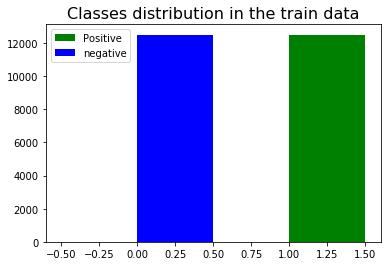

In [0]:
plt.hist(df[df['sentiment']==1]['sentiment'],bins=2, color = 'green',label = 'Positive')
plt.hist(df[df['sentiment']==0]['sentiment'],bins=2,color = 'blue',label ='negative')
plt.title('Classes distribution in the train data',fontsize = 16)
plt.legend()

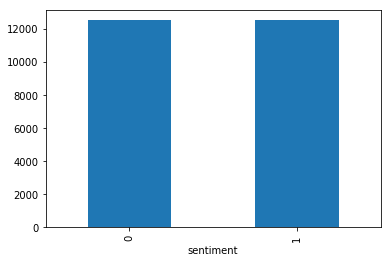

In [0]:
df.groupby('sentiment').size().plot(kind = 'bar')

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [0]:
def clean_review(raw_review):
    # 1. Remove HTML
      review_text = BeautifulSoup(raw_review,'lxml').get_text()
    # 2. Remove non-letters
      letters_only = re.sub('[^a-zA-Z]',' ', review_text)
    # 3. Convert to lower case
      lowercase_letters = letters_only.lower()
    # 4. split into individual words
      words = word_tokenize(lowercase_letters)
    # 5. Lemmatize
      words = list(map(lambda x :lemmatizer.lemmatize(x,'v'),words))
    # 5. remove stopwords
   
      words_non_stop = [ w for w in words if w not in stop_words]
    # 5. rejoin the words
      
      return(' '.join(words_non_stop))

In [0]:
df['clean_review'] = df['review'].apply(clean_review)

In [0]:
df.head()

,id,sentiment,review,clean_review
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",stuff go moment mj start listen music watch od...
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war worlds timothy hines entertain fil...
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",film start manager nicholas bell give welcome ...
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",must assume praise film greatest film opera ev...
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious explo...


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
max_features = 5000

vectorizer = CountVectorizer(analyzer = 'word',tokenizer = None,preprocessor = None,stop_words = 'english',max_features =max_features )

In [0]:
X_train = vectorizer.fit_transform(df['clean_review']).toarray()

In [0]:
X_train.shape

(25000, 5000)

In [0]:
vocab = vectorizer.get_feature_names()

In [0]:
len(vocab)

5000

In [0]:
type(X_train)

numpy.ndarray

In [0]:
import numpy as np

In [0]:
words_counts = np.sum(X_train,axis = 0)
word_count_dict = {}
for word,count in zip(vocab,words_counts):
    word_count_dict.update({word:count})
sort_word_count = sorted(word_count_dict.items(), key = lambda item: item[1],reverse = True)    
   

In [0]:
sort_word_count[:20]

[('movie', 44031),
 ('film', 40147),
 ('like', 20274),
 ('good', 15140),
 ('time', 12724),
 ('story', 11983),
 ('really', 11736),
 ('bad', 9301),
 ('people', 9285),
 ('great', 9058),
 ('way', 8026),
 ('make', 8023),
 ('movies', 7663),
 ('think', 7296),
 ('characters', 7154),
 ('character', 7023),
 ('watch', 6973),
 ('films', 6887),
 ('seen', 6679),
 ('life', 6628)]

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
RF = RandomForestClassifier(min_samples_split = 100, min_samples_leaf = 20,max_depth = 8, max_features = 'sqrt', random_state=10)

In [0]:
grid_values = {'n_estimators' : np.arange(60,101,10)}

In [0]:
RF_model = GridSearchCV(estimator = RF, param_grid = grid_values, scoring = 'roc_auc',cv=5,iid = True,n_jobs=1, refit = True, verbose =2)

In [0]:
RF_model.fit(X_train,df['sentiment'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=60 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=60, total=  11.4s
[CV] n_estimators=60 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


[CV] .................................. n_estimators=60, total=  10.8s
[CV] n_estimators=60 .................................................
[CV] .................................. n_estimators=60, total=  10.5s
[CV] n_estimators=60 .................................................
[CV] .................................. n_estimators=60, total=  10.5s
[CV] n_estimators=60 .................................................
[CV] .................................. n_estimators=60, total=  10.7s
[CV] n_estimators=70 .................................................
[CV] .................................. n_estimators=70, total=  12.2s
[CV] n_estimators=70 .................................................
[CV] .................................. n_estimators=70, total=  12.1s
[CV] n_estimators=70 .................................................
[CV] .................................. n_estimators=70, total=  12.1s
[CV] n_estimators=70 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  5.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=20,
                                              min_samples_split=100,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid=True, n_jobs=1,
             param_grid={'n_est

In [0]:
RF_model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X_train,df['sentiment'],test_size = 0.05)

In [0]:
ls

In [0]:
!unzip testData.tsv.zip

In [0]:
ls

In [0]:
test_df = pd.read_csv('testData.tsv',header = 0,delimiter = '\t',quoting =3)

In [0]:
test_df.shape

In [0]:
test_df.head()

In [0]:
prediction = RF_model.predict(X_test)

In [0]:
test_df['clean_review'] = test_df['review'].apply(clean_review)

In [0]:
X_test = vectorizer.transform(test_df['clean_review']).toarray()

# Deep Learning Solution

In [0]:
# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Flatten,Dense, Input, Dropout, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D,LSTM
from keras.models import Sequential,Model
from keras.optimizers import Adam

In [0]:
vocab_size = 5000
max_len = 300
tokenizer = Tokenizer(num_words = vocab_size)

In [0]:
df.head()

,id,sentiment,review,clean_review
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",stuff going moment mj started listening music ...
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war worlds timothy hines entertaining ...
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",film starts manager nicholas bell giving welco...
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",must assumed praised film greatest filmed oper...
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious explo...


In [0]:
tokenizer.fit_on_texts(df['clean_review'])

In [0]:
train_sequence = tokenizer.texts_to_sequences(df['clean_review'])

In [0]:
#test_sequence = tokenizer.texts_to_sequences(test_df['clean_review'])

In [0]:
X_train = pad_sequences(train_sequence,maxlen = max_len)
#X_test = pad_sequences(test_sequence,maxlen = max_len)

In [0]:
embed_size = 300

In [0]:
model = Sequential(
[ Embedding(input_dim = vocab_size, output_dim = embed_size,input_length = max_len),
Bidirectional(LSTM(128)),Dropout(rate = 0.25),Dense(1,activation = 'sigmoid')])


W0816 22:33:08.798835 140158113163136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 22:33:08.851938 140158113163136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 22:33:08.862596 140158113163136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 22:33:09.395926 140158113163136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0816 22:33:09.407330 

In [0]:
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

W0816 22:34:35.468808 140158113163136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0816 22:34:35.502322 140158113163136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0816 22:34:35.510162 140158113163136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          1500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,939,553
Trainable params: 1,939,553
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.fit(X_train,df['sentiment'],batch_size = 32, epochs = 3,validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 941s 42ms/step - loss: 0.4175 - acc: 0.8159 - val_loss: 0.3420 - val_acc: 0.8564
Epoch 2/3
22500/22500 [==============================] - 915s 41ms/step - loss: 0.2822 - acc: 0.8876 - val_loss: 0.3777 - val_acc: 0.8360
Epoch 3/3
22500/22500 [==============================] - 925s 41ms/step - loss: 0.2247 - acc: 0.9121 - val_loss: 0.3506 - val_acc: 0.8636
